In [1]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit import QuantumCircuit, Aer, transpile, assemble
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit 

# Noise Simulations

In [2]:
def noise_simulation(noise : bool, 
                     qc: qiskit.QuantumCircuit, 
                     measure_qubits : list,
                     shots : int, 
                     cmap: list):
    """
        This function simulate the quantum circuit with a certain noise.
        Input:
            noise: bool ; if you want to add a perfect simulation or not.
            qc: QuantumCircuit.
            measure_qubits : list ; the quantum bits to measure.
            shots: int; the number of shots.
            cmap : list; the coupling map of the circuit.
        Output:
            real_dict : dict ; dictionary with the histogram distribution.
    """

    if noise == False:
        ## Perfect simulation
        qc.measure(measure_qubits, measure_qubits)
        Simulation = Aer.get_backend('qasm_simulator')
        Quantum_Transpiler = transpile(qc, Simulation)
        Quantum_Obj = assemble(Quantum_Transpiler, shots=shots)
        real_dict = Simulation.run(Quantum_Obj).result().get_counts()

    else: 
        ## Noise simulation. Taken from the qiskit template.
        T1s = np.random.normal(70e3, 10e3, qc.num_qubits) # Sampled from normal distribution mean 50 microsec
        T2s = np.random.normal(50e3, 10e3, qc.num_qubits)  # Sampled from normal distribution mean 50 microsec

        # Truncate random T2s <= T1s
        T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qc.num_qubits)])

        # Instruction times (in nanoseconds)
        time_u1 = 0   # virtual gate
        time_u2 = 50  # (single X90 pulse)
        time_u3 = 100 # (two X90 pulses)
        time_cx = 300
        time_reset = 1000  # 1 microsecond
        time_measure = 1000 # 1 microsecond

        # QuantumError objects
        errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                        for t1, t2 in zip(T1s, T2s)]
        errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                        for t1, t2 in zip(T1s, T2s)]
        errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                    for t1, t2 in zip(T1s, T2s)]
        errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                    for t1, t2 in zip(T1s, T2s)]
        errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                    for t1, t2 in zip(T1s, T2s)]
        errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                    thermal_relaxation_error(t1b, t2b, time_cx))
                    for t1a, t2a in zip(T1s, T2s)]
                    for t1b, t2b in zip(T1s, T2s)]

        # Add errors to noise model
        noise_thermal = NoiseModel()
        for j in range(qc.num_qubits):
            noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
            noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
            noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
            noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
            noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
            for k in range(qc.num_qubits):
                noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

        ###

        qc.measure(measure_qubits, measure_qubits)
        sim_thermal = AerSimulator(noise_model=noise_thermal, shots=shots)
        circ_thermal = transpile(qc, sim_thermal, coupling_map=cmap)
        result_thermal = sim_thermal.run(circ_thermal).result()
        real_dict = result_thermal.get_counts(0)

    return real_dict

# Example

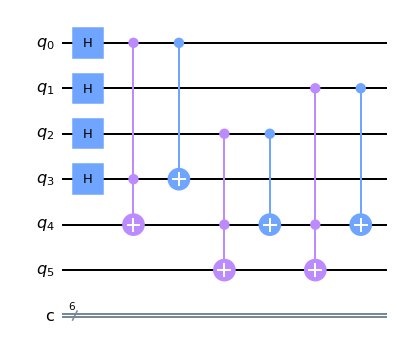

In [3]:
qc = QuantumCircuit(6,6)
qc.h([0,1,2,3])
qc.ccx(0,3,4)
qc.cx(0,3)
qc.ccx(2,4,5)
qc.cx(2,4)
qc.ccx(1,4,5)
qc.cx(1,4)
qc.draw('mpl')

In [4]:
cmap = [[0,1],[1,2],[2,3],[3,4],[4,5]]

noise_dict = noise_simulation(True, qc, [3,4,5], 1024, cmap)

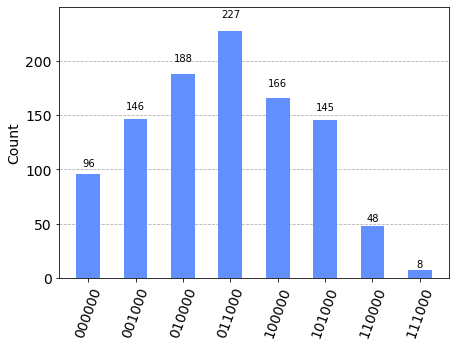

In [5]:
plot_histogram(noise_dict)

In [6]:
cmap = [[0,1],[1,2],[2,3],[3,4],[4,5]]

noise_dict = noise_simulation(False, qc, [3,4,5], 1024, cmap)

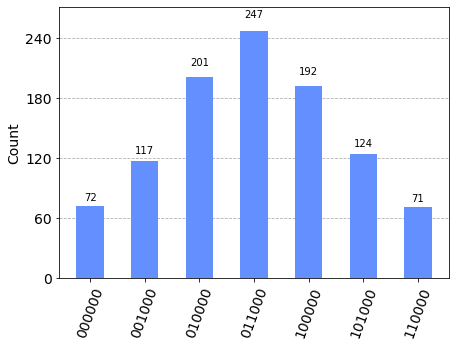

In [7]:
plot_histogram(noise_dict)